# Feature Adversaries Attack in TensorFlow v2

Before diving into the attack, let's first prepare a classification model. We utilize a script from the `examples` folders.

In [1]:
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist

# Step 1: Load the MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 2: Create the model
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

2022-07-29 18:03:53.344280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Step 3: Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

# Step 4: Train the ART classifier
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Train on 60000 samples
Epoch 1/3
   64/60000 [..............................] - ETA: 1:21 - loss: 2.3047 - accuracy: 0.1094

2022-07-29 18:04:10.187352: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-29 18:04:10.188228: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-29 18:04:10.259477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d5:00.0 name: Quadro P4000 computeCapability: 6.1
coreClock: 1.48GHz coreCount: 14 deviceMemorySize: 7.91GiB deviceMemoryBandwidth: 226.62GiB/s
2022-07-29 18:04:10.259521: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-29 18:04:10.264354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-29 18:04:10.264436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-07-29

60000/60000 [==============================] - 11s 188us/sample - loss: 0.1668 - accuracy: 0.9489
Epoch 2/3
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0848 - accuracy: 0.9740
Epoch 3/3
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0756 - accuracy: 0.9781
Accuracy on benign test examples: 96.5%


In [3]:
target = 2
y_test_adv_tar = np.zeros(y_test.shape)
for i in range(y_test.shape[0]):
    y_test_adv_tar[i, target] = 1.0

print(y_test_adv_tar[:2])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
from art.attacks.evasion import TargetedUniversalPerturbation

adv_crafter = TargetedUniversalPerturbation(
    classifier,
    attacker='fgsm',
    delta=0.2,
    attacker_params={'eps':0.5, 'verbose': True},
    max_iter=5,
    eps=5.5,
    norm=1.2)

x_adv = adv_crafter.generate(x=x_test, y=y_test_adv_tar)

# attack = FastGradientMethod(estimator=classifier, eps=0.2)
# x_test_adv = attack.generate(x=x_test)

In [10]:
noise = adv_crafter.noise
print(np.shape(noise))
print(np.shape(x_test))
rescaled_noise = noise.copy()
x_test_adv = x_test + rescaled_noise
preds_test_adv = np.argmax(classifier.predict(x_test_adv), axis=1) 
targeted_success_rate_test = np.sum(preds_test_adv == target) / len(x_test) 
print('targeted_success_rate_test: {:.1f} %'.format(targeted_success_rate_test*100))


(1, 28, 28, 1)
(10000, 28, 28, 1)
targeted_success_rate_test: 6.9 %


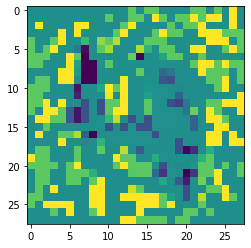

In [11]:
import matplotlib.pyplot as plt
plt.imshow(noise[0,:])

In [12]:
# Step 7: Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(x_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 53.790000000000006%


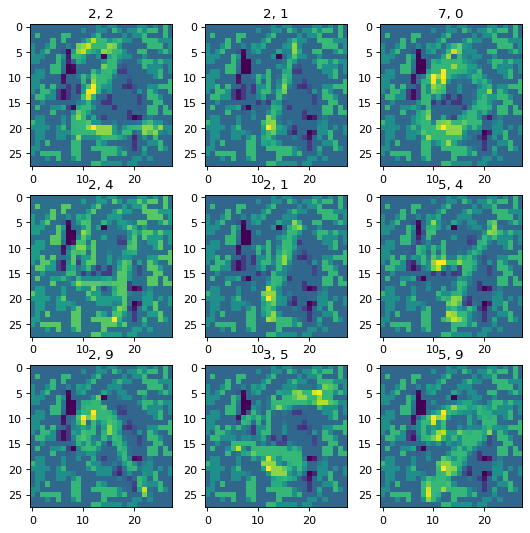

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8), dpi=80)

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_test_adv[i])
    plt.title(str(np.argmax(predictions[i]))+", "+ str(np.argmax(y_test[i])))

In [ ]:
from art.attacks.evasion import TargetedUniversalPerturbation
adv_crafter = TargetedUniversalPerturbation(
    classifier,
    attacker='fgsm',
    delta=0.2,
    attacker_params={'targeted':True, 'eps':0.6},
    max_iter=10,
    eps=5.5,
    norm=2)

In [ ]:
# selecting 1000 images for each class in 10 classes 
x_part_train = x_train[:100*10]
y_part_train = y_train[:100*10]

# set target label
target = 1
y_train_adv_tar = np.zeros(y_part_train.shape)
for i in range(y_part_train.shape[0]):
    y_train_adv_tar[i, target] = 1.0

In [ ]:
x_adv = adv_crafter.generate(x_part_train, y=y_train_adv_tar)

In [ ]:
noise = adv_crafter.noise[0,:]
x_train_adv = x_train + noise
x_test_adv = x_test + noise

preds_train_adv = np.argmax(classifier.predict(x_train_adv), axis=1)
preds_test_adv = np.argmax(classifier.predict(x_test_adv), axis=1) 
targeted_success_rate_train = np.sum(preds_train_adv == target) / len(x_train)
targeted_success_rate_test = np.sum(preds_test_adv == target) / len(x_test) 
print('targeted_success_rate_train: {:.1f} %'.format(targeted_success_rate_train*100))
print('targeted_success_rate_test: {:.1f} %'.format(targeted_success_rate_test*100))